In [35]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from astroML.classification import GMMBayes

from sklearn.neighbors import KNeighborsClassifier

from sklearn import preprocessing

from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA

from astroML.utils import completeness_contamination

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [2]:
data=h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

In [3]:
print(data.keys())

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>


In [4]:
mtot=data['mtot'][:]
q=data['q'][:]
z=data['z'][:]
iota=data['iota'][:]
psi=data['psi'][:]
chi1x=data['chi1x'][:]
chi1y=data['chi1y'][:]
chi1z=data['chi1z'][:]
chi2x=data['chi2x'][:]
chi2y=data['chi2y'][:]
chi2z=data['chi2z'][:]

snr=data['snr'][:]
det=data['det'][:]

In [5]:
X = np.array([mtot,q,z,iota,psi,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z]).T

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scale=scaler.fit_transform(X)

In [27]:
#create a subset
X_sub=X[::1000]
det_sub=det[::1000]
X_scale_sub=X_scale[::1000]

X_train, X_test, y_train, y_test = train_test_split(X, det, test_size=0.5, random_state=1)

X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, det_sub, test_size=0.5, random_state=1)

X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_scale_sub, det_sub, test_size=0.5, random_state=1)

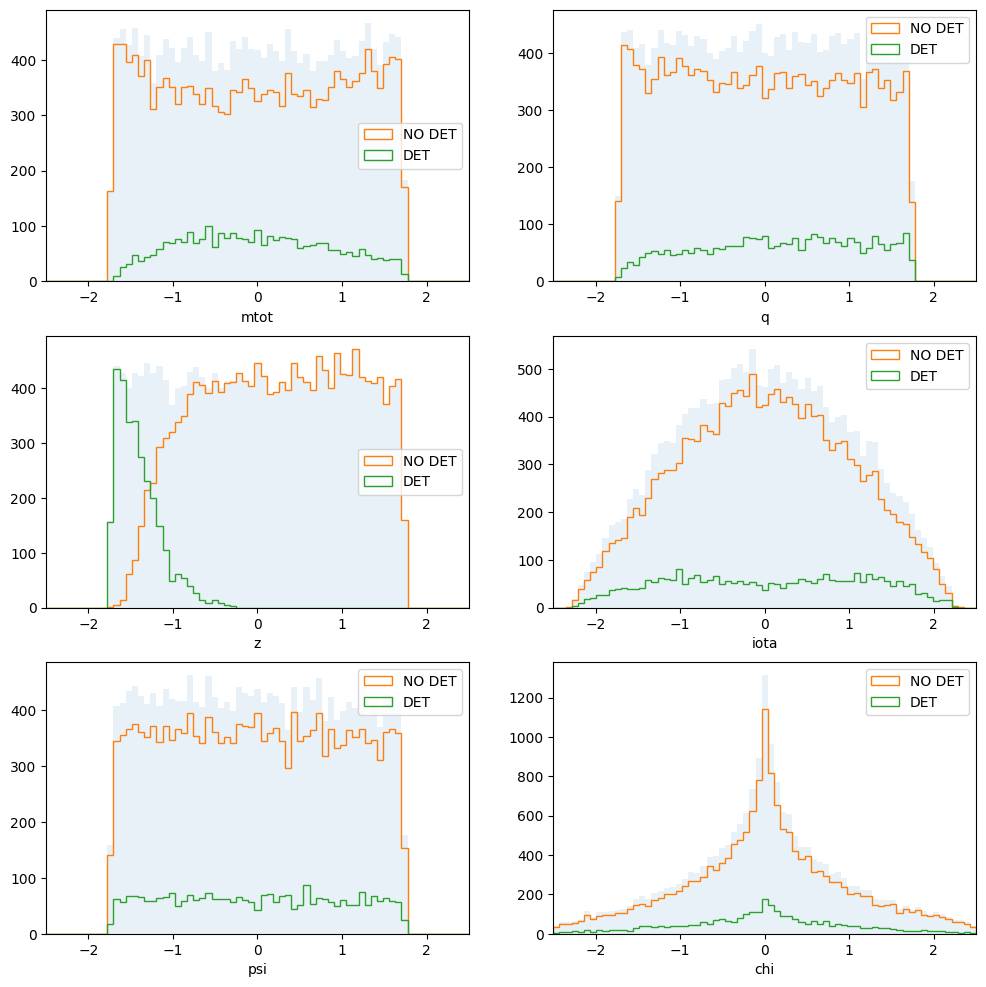

In [8]:
fig, ax = plt.subplots(3, 2, figsize = (12, 12))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1], ax[2,0], ax[2,1]]
bins=np.linspace(-2.5, 2.5, 70)

lab=['mtot', 'q', 'z', 'iota', 'psi', 'chi']

for a,i in zip(axs, range(len(X_scale_sub[0,:]))):
    a.hist(X_scale_sub[:,i], bins=bins, alpha=0.1)
    a.hist(X_scale_sub[:,i][det_sub==0], bins=bins, histtype='step', lw=1, label='NO DET')
    a.hist(X_scale_sub[:,i][det_sub==1], bins=bins, histtype='step', lw=1, label='DET')
    
    a.set_xlabel(lab[i])
    a.set_xlim(-2.5,2.5)
    a.legend()

plt.show()

In [20]:
def rms_error(x, y, clf):
    return np.sqrt(np.sum((clf.predict(x) - y) ** 2)
                   / len(y))

def errors_cv(X, y, clf):
    cverr = []
    trainerr = []
    
    for train_index, cv_index in kf.split(X):
        X_train, X_cv = X[train_index], X[cv_index]
        y_train, y_cv = y[train_index], y[cv_index]
        
        clf.fit(X_train, y_train)
        trainerr.append(rms_error(X_train, y_train, clf))
        cverr.append(rms_error(X_cv, y_cv, clf))
        #print(trainerr, cverr)
    
    return np.median(cverr), np.median(trainerr)

kf = KFold(n_splits=5, shuffle=True, random_state=10)

In [90]:
nt = np.linspace(15, 30, 15, dtype=int)
cverr_RF =[]
trainerr_RF = []

for n in nt:
    ranfor = RandomForestClassifier(n)
    cverr, trainerr = errors_cv(X_sub_train, y_sub_train, ranfor)
    cverr_RF.append(cverr)
    trainerr_RF.append(trainerr)
    
nt_best = nt[cverr_RF == min(cverr_RF)][0]
print('best number of trees:',nt_best)

best number of components: 28


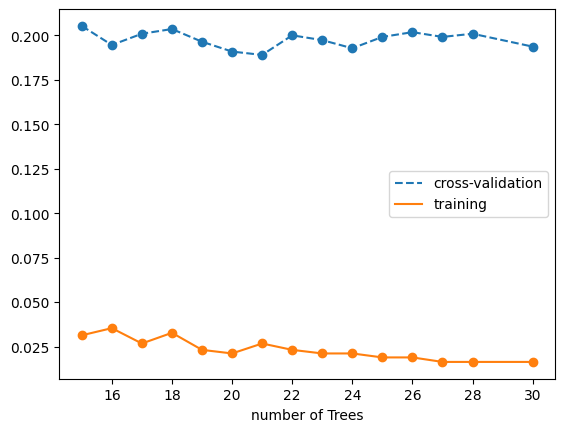

In [10]:
plt.scatter(nt, cverr_RF)
plt.scatter(nt, trainerr_RF)
plt.plot(nt, cverr_RF, '--', label='cross-validation')
plt.plot(nt, trainerr_RF, '-', label='training')
plt.legend()
plt.xlabel('number of Trees')
plt.show()

In [34]:
ranfor = RandomForestClassifier(nt_best, random_state=2)
ranfor.fit(X_sub_train,y_sub_train)

train_pred_sub = ranfor.predict(X_sub_train)
test_pred_sub = ranfor.predict(X_sub_test)

completeness_train_sub, contamination_train_sub = completeness_contamination(train_pred_sub, y_sub_train)

completeness_test_sub, contamination_test_sub = completeness_contamination(test_pred_sub, y_sub_test)

print("\ncompleteness train:", round(float(completeness_train_sub),3))
print("contamination train:", round(float(contamination_train_sub),3))

print("\ncompleteness test:", round(float(completeness_test_sub),3))
print("contamination test:", round(float(contamination_test_sub),3))


completeness train: 0.996
contamination train: 0.002

completeness test: 0.827
contamination test: 0.103


In [30]:
gradboost = GradientBoostingClassifier()
gradboost.fit(X_sub_train,y_sub_train)

train_pred_sub = gradboost.predict(X_sub_train)
test_pred_sub = gradboost.predict(X_sub_test)

completeness_train_sub, contamination_train_sub = completeness_contamination(train_pred_sub, y_sub_train)

completeness_test_sub, contamination_test_sub = completeness_contamination(test_pred_sub, y_sub_test)

print("\ncompleteness train:", round(float(completeness_train_sub),3))
print("contamination train:", round(float(contamination_train_sub),3))

print("\ncompleteness test:", round(float(completeness_test_sub),3))
print("contamination test:", round(float(contamination_test_sub),3))


completeness train: 0.889
contamination train: 0.075

completeness test: 0.839
contamination test: 0.099


In [29]:
#try with the scaled data

gradboost = GradientBoostingClassifier()
gradboost.fit(X_s_train,y_s_train)

train_pred_sub = gradboost.predict(X_s_train)
test_pred_sub = gradboost.predict(X_s_test)

completeness_train_sub, contamination_train_sub = completeness_contamination(train_pred_sub, y_s_train)

completeness_test_sub, contamination_test_sub = completeness_contamination(test_pred_sub, y_s_test)

print("\ncompleteness train:", round(float(completeness_train_sub),3))
print("contamination train:", round(float(contamination_train_sub),3))

print("\ncompleteness test:", round(float(completeness_test_sub),3))
print("contamination test:", round(float(contamination_test_sub),3))


completeness train: 0.889
contamination train: 0.075

completeness test: 0.839
contamination test: 0.099


In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=8)

ncom = np.linspace(1, 20, 20, dtype=int)
cverr_GMM =[]
trainerr_GMM = []

for n in ncom:
    gmmb = GMMBayes(n, random_state=8)
    cverr, trainerr = errors_cv(X_sub_train, y_sub_train, gmmb)
    cverr_GMM.append(cverr)
    trainerr_GMM.append(trainerr)
    
ncom_best = ncom[cverr_GMM == min(cverr_GMM)][0]
print('best number of components:',ncom_best)

best number of components: 3


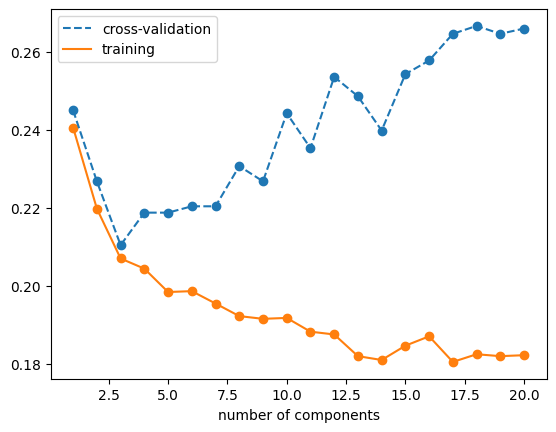

In [14]:
plt.scatter(ncom, cverr_GMM)
plt.scatter(ncom, trainerr_GMM)
plt.plot(ncom, cverr_GMM, '--', label='cross-validation')
plt.plot(ncom, trainerr_GMM, '-', label='training')
plt.legend()
plt.xlabel('number of components')
plt.show()

In [15]:
gmm = GMMBayes(ncom_best, random_state=5)
gmm.fit(X_sub_train,y_sub_train)

train_pred_sub = gmm.predict(X_sub_train)
test_pred_sub = gmm.predict(X_sub_test)

completeness_train_sub, contamination_train_sub = completeness_contamination(train_pred_sub, y_sub_train)

completeness_test_sub, contamination_test_sub = completeness_contamination(test_pred_sub, y_sub_test)

print("\ncompleteness train:", round(float(completeness_train_sub),3))
print("contamination train:", round(float(contamination_train_sub),3))

print("\ncompleteness test:", round(float(completeness_test_sub),3))
print("contamination test:", round(float(contamination_test_sub),3))


completeness train: 0.879
contamination train: 0.169

completeness test: 0.833
contamination test: 0.15


In [25]:
#try to reduce the data

ndim = np.linspace(2, 11, 10, dtype=int)

best_nt=[]
complet=[]
contam=[]

for nd in ndim:
    pca = PCA(n_components = nd)
    X_reduced_sub = pca.fit_transform(X_sub)
    
    X_sub_r_train, X_sub_r_test, y_sub_r_train, y_sub_r_test = train_test_split(X_reduced_sub, det_sub,
                                                                                test_size=0.5, random_state=1)
    
    nt = np.linspace(5, 25, 25, dtype=int)
    cverr_RF =[]
    trainerr_RF = []

    for n in nt:
        ranfor = RandomForestClassifier(n)
        cverr, trainerr = errors_cv(X_sub_r_train, y_sub_r_train, ranfor)
        cverr_RF.append(cverr)
        trainerr_RF.append(trainerr)
    
    nt_best = nt[cverr_RF == min(cverr_RF)][0]
    
    ranfor = RandomForestClassifier(nt_best)
    ranfor.fit(X_sub_r_train,y_sub_r_train)

    train_pred_sub = ranfor.predict(X_sub_r_train)
    test_pred_sub = ranfor.predict(X_sub_r_test)
    
    completeness_test_sub, contamination_test_sub = completeness_contamination(test_pred_sub, y_sub_r_test)
    
    best_nt.append(nt_best)
    complet.append(round(float(completeness_test_sub),3))
    contam.append(round(float(contamination_test_sub),3))

results = np.array([ndim, best_nt, complet, contam]).T

col_names=["number of dimensions", "best number of trees", "completeness", "contamination"]

print(tabulate(results, headers=col_names, tablefmt="fancy_grid"))

╒════════════════════════╤════════════════════════╤════════════════╤═════════════════╕
│   number of dimensions │   best number of trees │   completeness │   contamination │
╞════════════════════════╪════════════════════════╪════════════════╪═════════════════╡
│                      2 │                     10 │          0.741 │           0.159 │
├────────────────────────┼────────────────────────┼────────────────┼─────────────────┤
│                      3 │                     13 │          0.782 │           0.146 │
├────────────────────────┼────────────────────────┼────────────────┼─────────────────┤
│                      4 │                     14 │          0.816 │           0.132 │
├────────────────────────┼────────────────────────┼────────────────┼─────────────────┤
│                      5 │                     16 │          0.81  │           0.132 │
├────────────────────────┼────────────────────────┼────────────────┼─────────────────┤
│                      6 │                 

In [22]:
ndim = np.linspace(2, 11, 10, dtype=int)

best_nc=[]
complet=[]
contam=[]

for nd in ndim:
    pca = PCA(n_components = nd, random_state=10)
    X_reduced_sub = pca.fit_transform(X_sub)
    
    X_sub_r_train, X_sub_r_test, y_sub_r_train, y_sub_r_test = train_test_split(X_reduced_sub, det_sub, test_size=0.5, 
                                                                        random_state=1)
    
    nc = np.linspace(2, 10, 9, dtype=int)
    cverr_GMM =[]
    trainerr_GMM = []

    for n in nc:
        gmm = GMMBayes(n, random_state=10)
        cverr, trainerr = errors_cv(X_sub_r_train, y_sub_r_train, gmm)
        cverr_GMM.append(cverr)
        trainerr_GMM.append(trainerr)
    
    nc_best = nc[cverr_GMM == min(cverr_GMM)][0]
    
    gmm = GMMBayes(nc_best, random_state=10)
    gmm.fit(X_sub_r_train,y_sub_r_train)

    train_pred_sub = gmm.predict(X_sub_r_train)
    test_pred_sub = gmm.predict(X_sub_r_test)
    
    completeness_test_sub, contamination_test_sub = completeness_contamination(test_pred_sub, y_sub_r_test)
    
    best_nc.append(nc_best)
    complet.append(round(float(completeness_test_sub),3))
    contam.append(round(float(contamination_test_sub),3))

results = np.array([ndim, best_nc, complet, contam]).T

col_names=["number of dimensions", "best number of components", "completeness", "contamination"]

print(tabulate(results, headers=col_names, tablefmt="fancy_grid"))

/home/sale/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/sale/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


╒════════════════════════╤═════════════════════════════╤════════════════╤═════════════════╕
│   number of dimensions │   best number of components │   completeness │   contamination │
╞════════════════════════╪═════════════════════════════╪════════════════╪═════════════════╡
│                      2 │                           5 │          0.837 │           0.181 │
├────────────────────────┼─────────────────────────────┼────────────────┼─────────────────┤
│                      3 │                           7 │          0.829 │           0.191 │
├────────────────────────┼─────────────────────────────┼────────────────┼─────────────────┤
│                      4 │                           7 │          0.835 │           0.175 │
├────────────────────────┼─────────────────────────────┼────────────────┼─────────────────┤
│                      5 │                           9 │          0.849 │           0.196 │
├────────────────────────┼─────────────────────────────┼────────────────┼───────

In [26]:
ndim = np.linspace(2, 11, 10, dtype=int)

complet=[]
contam=[]

for nd in ndim:
    pca = PCA(n_components = nd, random_state=10)
    X_reduced_sub = pca.fit_transform(X_sub)
    
    X_sub_r_train, X_sub_r_test, y_sub_r_train, y_sub_r_test = train_test_split(X_reduced_sub, det_sub, test_size=0.5, 
                                                                        random_state=1)
    
    gradboost = GradientBoostingClassifier(random_state=10)
    gradboost.fit(X_sub_r_train,y_sub_r_train)

    train_pred_sub = gradboost.predict(X_sub_r_train)
    test_pred_sub = gradboost.predict(X_sub_r_test)
    
    completeness_test_sub, contamination_test_sub = completeness_contamination(test_pred_sub, y_sub_r_test)
    
    complet.append(round(float(completeness_test_sub),3))
    contam.append(round(float(contamination_test_sub),3))
    
results = np.array([ndim, complet, contam]).T

col_names=["number of dimensions", "completeness", "contamination"]

print(tabulate(results, headers=col_names, tablefmt="fancy_grid"))

╒════════════════════════╤════════════════╤═════════════════╕
│   number of dimensions │   completeness │   contamination │
╞════════════════════════╪════════════════╪═════════════════╡
│                      2 │          0.793 │           0.146 │
├────────────────────────┼────────────────┼─────────────────┤
│                      3 │          0.788 │           0.145 │
├────────────────────────┼────────────────┼─────────────────┤
│                      4 │          0.828 │           0.124 │
├────────────────────────┼────────────────┼─────────────────┤
│                      5 │          0.822 │           0.123 │
├────────────────────────┼────────────────┼─────────────────┤
│                      6 │          0.829 │           0.127 │
├────────────────────────┼────────────────┼─────────────────┤
│                      7 │          0.832 │           0.119 │
├────────────────────────┼────────────────┼─────────────────┤
│                      8 │          0.828 │           0.121 │
├───────

In [38]:
pca = PCA(n_components = 8, random_state=10)
X_best = pca.fit_transform(X_sub)
    
X_best_train, X_best_test, y_best_train, y_best_test = train_test_split(X_best, det_sub, test_size=0.5, 
                                                                        random_state=1)

gmm = GMMBayes(4, random_state=10)
gmm.fit(X_best_train,y_best_train)

train_pred = gmm.predict(X_best_train)
test_pred = gmm.predict(X_best_test)

completeness_train, contamination_train = completeness_contamination(train_pred, y_best_train)

completeness_test, contamination_test = completeness_contamination(test_pred, y_best_test)

print("\ncompleteness train:", round(float(completeness_train),3))
print("contamination train:", round(float(contamination_train),3))

print("\ncompleteness test:", round(float(completeness_test),3))
print("contamination test:", round(float(contamination_test),3))

accuracy = accuracy_score(y_best_test, test_pred)

print("\naccuracy:", round(float(accuracy),3))


completeness train: 0.885
contamination train: 0.21

completeness test: 0.869
contamination test: 0.209

accuracy: 0.946


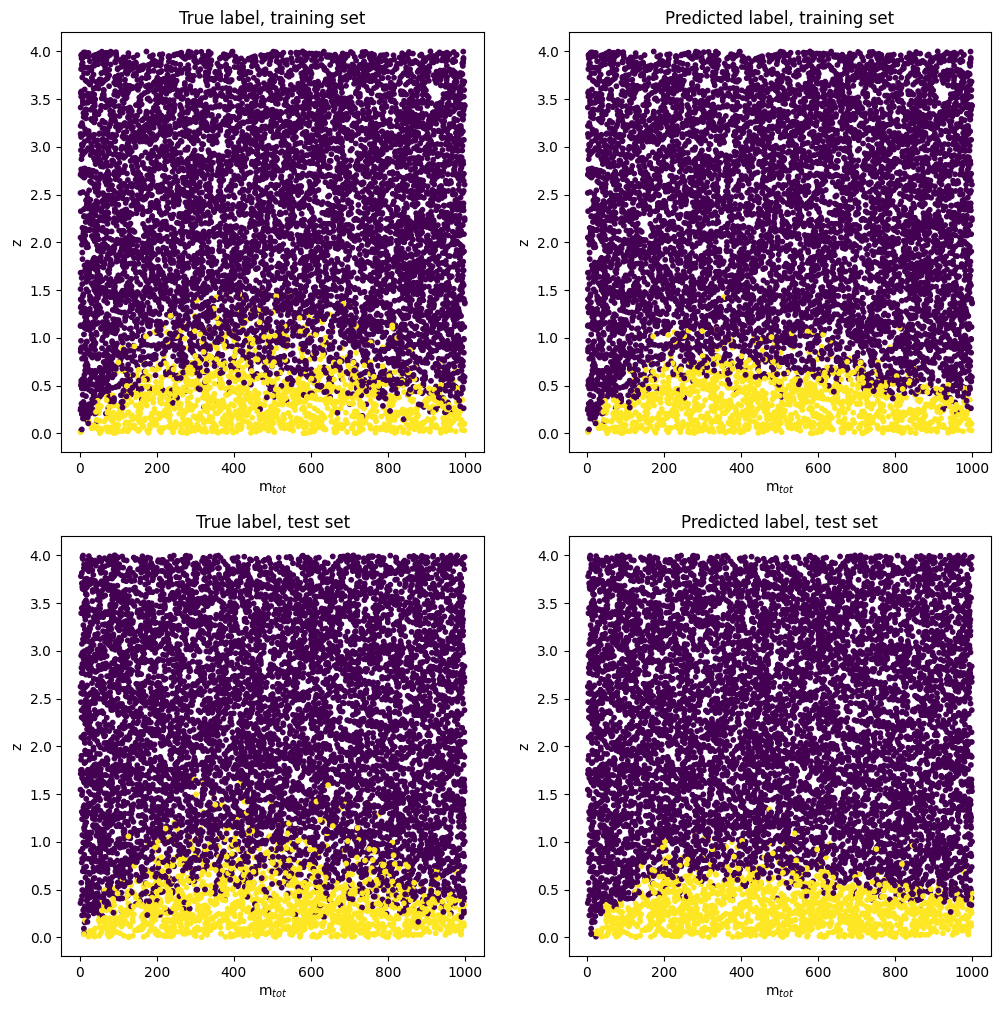

In [28]:
#consider mtot and z and compare the true and predicted label

s=10

fig = plt.figure(figsize=(12,12))

ax=fig.add_subplot(221)
plt.scatter(X_sub_train[:,0], X_sub_train[:,2], c=y_sub_train, s=s)
plt.xlabel('m$_{tot}$')
plt.ylabel('z')
plt.title('True label, training set')

ax=fig.add_subplot(222)
plt.scatter(X_sub_train[:,0], X_sub_train[:,2], c=train_pred, s=s)
plt.xlabel('m$_{tot}$')
plt.ylabel('z')
plt.title('Predicted label, training set')

ax=fig.add_subplot(223)
plt.scatter(X_sub_test[:,0], X_sub_test[:,2], c=y_sub_test, s=s)
plt.xlabel('m$_{tot}$')
plt.ylabel('z')
plt.title('True label, test set')

ax=fig.add_subplot(224)
plt.scatter(X_sub_test[:,0], X_sub_test[:,2], c=test_pred, s=s)
plt.xlabel('m$_{tot}$')
plt.ylabel('z')
plt.title('Predicted label, test set')

plt.show()

In [37]:
pca = PCA(n_components = 11, random_state=10)
X_best = pca.fit_transform(X_sub)
    
X_best_train, X_best_test, y_best_train, y_best_test = train_test_split(X_best, det_sub, test_size=0.5, 
                                                                        random_state=1)

gradboost = GradientBoostingClassifier(random_state=10)
gradboost.fit(X_best_train,y_best_train)

train_pred = gradboost.predict(X_best_train)
test_pred = gradboost.predict(X_best_test)

completeness_train, contamination_train = completeness_contamination(train_pred, y_best_train)

completeness_test, contamination_test = completeness_contamination(test_pred, y_best_test)

print("\ncompleteness train:", round(float(completeness_train),3))
print("contamination train:", round(float(contamination_train),3))

print("\ncompleteness test:", round(float(completeness_test),3))
print("contamination test:", round(float(contamination_test),3))

accuracy = accuracy_score(y_best_test, test_pred)

print("\naccuracy:", round(float(accuracy),3))


completeness train: 0.889
contamination train: 0.08

completeness test: 0.85
contamination test: 0.102

accuracy: 0.963


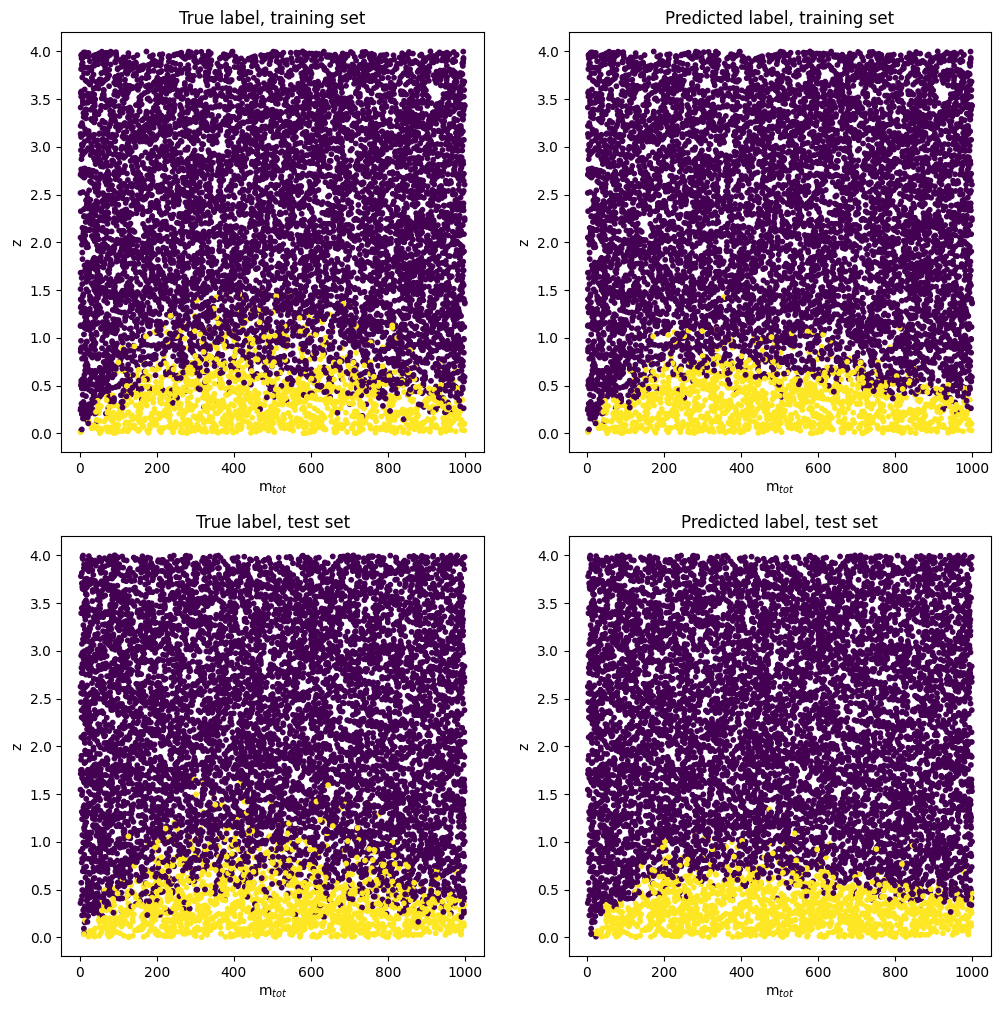

In [29]:
fig = plt.figure(figsize=(12,12))

ax=fig.add_subplot(221)
plt.scatter(X_sub_train[:,0], X_sub_train[:,2], c=y_sub_train, s=s)
plt.xlabel('m$_{tot}$')
plt.ylabel('z')
plt.title('True label, training set')

ax=fig.add_subplot(222)
plt.scatter(X_sub_train[:,0], X_sub_train[:,2], c=train_pred, s=s)
plt.xlabel('m$_{tot}$')
plt.ylabel('z')
plt.title('Predicted label, training set')

ax=fig.add_subplot(223)
plt.scatter(X_sub_test[:,0], X_sub_test[:,2], c=y_sub_test, s=s)
plt.xlabel('m$_{tot}$')
plt.ylabel('z')
plt.title('True label, test set')

ax=fig.add_subplot(224)
plt.scatter(X_sub_test[:,0], X_sub_test[:,2], c=test_pred, s=s)
plt.xlabel('m$_{tot}$')
plt.ylabel('z')
plt.title('Predicted label, test set')

plt.show()

In [43]:
#with only a small subset we obtain quite a similar result

X_1 = np.array([mtot,q,z,iota]).T
X_1=X_1[::1000]

X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, det_sub, test_size=0.5, random_state=1)

gradboost = GradientBoostingClassifier()
gradboost.fit(X_1_train,y_1_train)

train_pred_1 = gradboost.predict(X_1_train)
test_pred_1 = gradboost.predict(X_1_test)

completeness_train, contamination_train = completeness_contamination(train_pred_1, y_1_train)

completeness_test, contamination_test = completeness_contamination(test_pred_1, y_1_test)

print("\ncompleteness train:", round(float(completeness_train),3))
print("contamination train:", round(float(contamination_train),3))

print("\ncompleteness test:", round(float(completeness_test),3))
print("contamination test:", round(float(contamination_test),3))


completeness train: 0.874
contamination train: 0.08

completeness test: 0.847
contamination test: 0.104
